In [1]:
import pyarrow.parquet as pq
import numpy as np
import pandas as pd
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import AUC
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')


In [2]:
file = 'QCDToGGQQ_IMGjet_RH1all_jet0_run0_n36272.test.snappy.parquet'

In [3]:
data = pq.read_table(file)

In [4]:
data = data.to_pandas()

In [5]:
data.head()

,X_jets,pt,m0,y
0,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",112.411095,21.098248,0.0
1,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",95.220406,14.030600,1.0
2,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",97.007317,17.728968,1.0
3,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",82.490311,14.702741,0.0
4,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.328483...",102.539238,19.456257,0.0


In [6]:
data['pt'].min()

70.3982162475586

In [7]:
pt = data['pt'].to_numpy()
m0 = data['m0'].to_numpy()
y = data['y'].to_numpy()

In [8]:
X_jets = data['X_jets'].to_numpy()

In [9]:
X = np.zeros((36272,3,125,125))

In [10]:
for i in range(0,36272):
    for j in range(0,3):
        for k in range(0,125):
            for l in range(0,125):
                X[i][j][k][l] = X_jets[i][j][k][l]

In [11]:
del data
del X_jets

In [12]:
y = to_categorical(y, num_classes=2)

In [13]:
pt.shape

(36272,)

In [21]:

input1 = Input(shape=(3,125,125))
input2 = Input(shape=(1,))
input3 = Input(shape=(1,))
x1 = Conv2D(3, (5,5), activation='relu', input_shape=(3, 125, 125), data_format='channels_first', padding='same')(input1)
x1 = MaxPooling2D((5,5), data_format='channels_first')(x1)
x1 = Flatten()(x1)
x1 = Dense(12, activation='relu')(x1)
x2 = Dense(4, activation='relu')(input2)
x3 = Dense(4, activation='relu')(input3)

x = Concatenate(axis=1)([x1, x2, x3])
output = Dense(2, activation='softmax')(x)
model = Model(inputs=[input1, input2, input3], outputs=output)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3, 125, 125  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 3, 125, 125)  228         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 3, 25, 25)    0           ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 1875)         0           ['max_pooling2d[0][0]']      

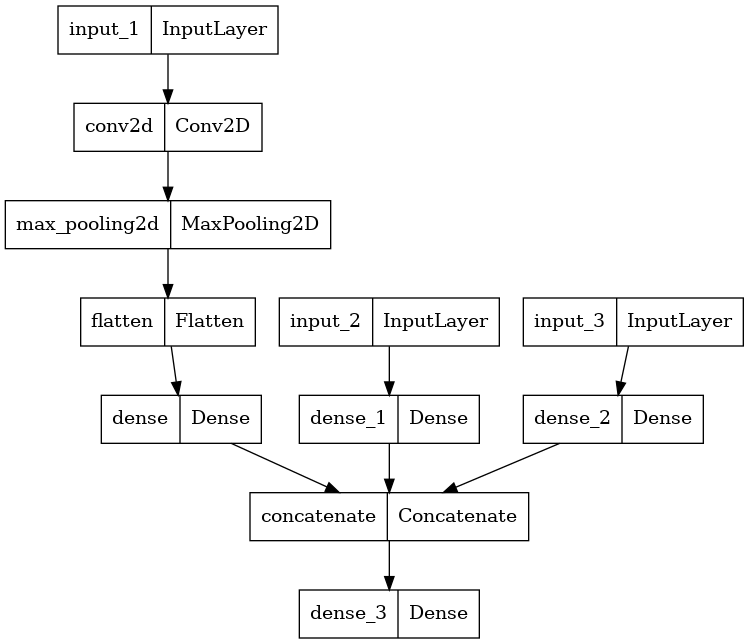

In [22]:
model.summary()
tf.keras.utils.plot_model(model)

In [23]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.0005), metrics=[AUC()])

In [24]:
with tf.device('/gpu:0'):
    model.fit([X, pt, m0], y, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
1021/1021 [==============================] - 14s 14ms/step - loss: 6.1948 - auc: 0.5858 - val_loss: 2.0117 - val_auc: 0.6429
Epoch 2/10
1021/1021 [==============================] - 12s 12ms/step - loss: 1.3758 - auc: 0.6577 - val_loss: 0.8610 - val_auc: 0.6683
Epoch 3/10
1021/1021 [==============================] - 12s 12ms/step - loss: 0.7029 - auc: 0.7002 - val_loss: 0.6296 - val_auc: 0.7243
Epoch 4/10
1021/1021 [==============================] - 12s 12ms/step - loss: 0.6042 - auc: 0.7456 - val_loss: 0.6179 - val_auc: 0.7396
Epoch 5/10
1021/1021 [==============================] - 12s 12ms/step - loss: 0.5899 - auc: 0.7592 - val_loss: 0.5967 - val_auc: 0.7645
Epoch 6/10
1021/1021 [==============================] - 12s 12ms/step - loss: 0.5832 - auc: 0.7657 - val_loss: 0.5872 - val_auc: 0.7658
Epoch 7/10
1021/1021 [==============================] - 12s 12ms/step - loss: 0.5770 - auc: 0.7714 - val_loss: 0.5954 - val_auc: 0.7581
Epoch 8/10
1021/1021 [==========================

Train AUC Score: 0.785

Validation AUC Score: 0.771